In [4]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from flax import nnx
from jax.flatten_util import ravel_pytree
from tqdm.auto import trange

from central_flows_jax import Flow, GradientDescent

rngs = nnx.Rngs(0)
n, d, m = 128, 8, 16
x = rngs.normal((n, d))
y = rngs.normal((n,))
model = nnx.Sequential(
    nnx.Linear(d, m, rngs=rngs),
    nnx.swish,
    nnx.Linear(m, m, rngs=rngs),
    nnx.swish,
    nnx.Linear(m, 1, rngs=rngs),
    lambda x: x[..., 0],
)
p0, unravel = ravel_pytree(model)
f = lambda p, x: unravel(p)(x)
loss_fn = lambda p: jnp.mean((f(p, x) - y) ** 2)

opt = GradientDescent(lr=1e-1)
state0 = opt.init(p0)
flow = Flow(loss_fn, opt)
U0 = rngs.normal((len(p0), 5))
discrete = stable = central = (p0, state0, U0)
out = []
for _ in trange(1000):
    aux = {}
    discrete, aux["discrete"] = flow.discrete(*discrete, midpoint=True)
    stable, aux["stable"] = flow.stable(*stable)
    central, aux["central"] = flow.central(*central)
    aux["central"]["L_pred"] = aux["central"]["L"] + jnp.trace(aux["central"]["X"])
    out.append(jax.device_get(aux))
out = jax.tree.map(lambda *xs: jnp.stack(xs), *out)


  0%|          | 0/1000 [00:00<?, ?it/s]

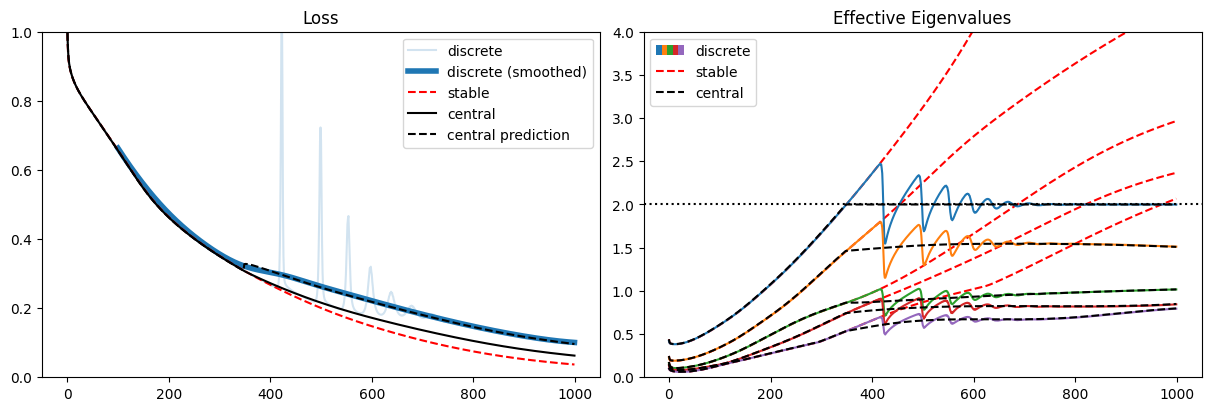

In [6]:
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import Patch
from scipy.ndimage import gaussian_filter1d

fig, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
plt.sca(axs[0])
plt.plot(out["discrete"]["L"], label="discrete", alpha=0.2, c="C0")

sigma = 50
smoothed_loss = gaussian_filter1d(out["discrete"]["L"], sigma=50, mode="nearest")
idx = range(2 * sigma, len(smoothed_loss))
plt.plot(idx, smoothed_loss[idx], label="discrete (smoothed)", lw=4)
plt.plot(out["stable"]["L"], label="stable", ls="--", c="r")
plt.plot(out["central"]["L"], label="central", c="k")
plt.plot(out["central"]["L_pred"], label="central prediction", ls="--", c="k")
plt.title("Loss")
plt.ylim(0, 1)
plt.legend()

plt.sca(axs[1])
plt.plot(out["discrete"]["eigs"])
plt.plot(out["stable"]["eigs"], ls="--", c="r", zorder=-1)
plt.plot(out["central"]["eigs"], ls="--", c="k")
plt.axhline(2, ls=":", c="k")
plt.title("Effective Eigenvalues")

k = out["discrete"]["eigs"].shape[1]
patches = tuple(Patch(fc=f"C{i}") for i in range(k))
plt.legend(
    [patches, plt.Line2D([], [], ls="--", c="r"), plt.Line2D([], [], ls="--", c="k")],
    ["discrete", "stable", "central"],
    handler_map={patches: HandlerTuple(ndivide=None, pad=0)},
)
plt.ylim(0, 4)
plt.savefig("example.png", dpi=300)